In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [62]:
import glob

from scipy.io import loadmat # the function is used to mat file

import os

In [101]:
import csv

In [121]:
import pandas as pd

In [160]:
import cv2

In [2]:
%matplotlib inline
%pdb

Automatic pdb calling has been turned ON


In [173]:
!pwd

/home/big_muscle/gaze_estimation


In [83]:
def show_images(images_list, cols = 1, titles = None):
        """Display a list of images in a single figure with matplotlib.

        Parameters
        ---------
        images: List of np.arrays compatible with plt.imshow.

        cols (Default = 1): Number of columns in figure (number of rows is 
                            set to np.ceil(n_images/float(cols))).

        titles: List of titles corresponding to each image. Must have
                the same length as titles.
        """
        images = [plt.imread(i) for i in images_list]
        assert((titles is None)or (len(images) == len(titles)))
        n_images = len(images)
        if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
        fig = plt.figure()
        for n, (image, title) in enumerate(zip(images, titles)):
            a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
            if image.ndim == 2:
                plt.gray()
            plt.imshow(image)
            a.set_title(title)
        fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
        plt.show()

In [158]:
image_dir_root = 'data/MPIIFaceGaze/'
person = 1
day = 1
class Dataset():
    def __init__(self, rootdir):
        self.rootdir = rootdir
        self.person = None
        self.day = None
    def _contrastdir(self, person, day):
        self.person = person
        self.day = day
        self.persondir = self.rootdir+'p{:02}'.format(person)
        self.daydir = self.persondir+'/day{:02}'.format(day)
        self.images_dirlist = glob.glob(self.daydir+'/*.jpg')
        self.annotation_dir = self.persondir+'/p{:02}.txt'.format(person)
        self.num_images = len(self.images_dirlist)
        # self.persons = [i[0] for i in os.walk(self.persondir)]
        self.calibration_dir = self.persondir+'/Calibration'

    def _get_camera_address(self):
        "Return three calibration camera.mat address."
        calibration_files = self.calibration_dir+'/Camera.mat'
        return calibration_files
    
    def _read_camara_mx(self):
        '''
        Read Camera matrix mat file.
        return mtx, dist from camera mx

        Parameter
        ---------
        get_calibration(person)[0]
        '''
        file_path = self._get_camera_address()
        mx = loadmat(file_path)
        cameraMatrix = mx['cameraMatrix']
        distCoeffs = mx['distCoeffs']
        retval = mx['retval']
        rvecs = mx['rvecs'] # rotation vector
        tvecs = mx['tvecs'] # translation vector
        return cameraMatrix, distCoeffs, rvecs, tvecs

    def _annotation_file_reader(self):
        '''
        Read annotation file and return right format as indicted in the paper.
        '''
        return pd.read_csv(self.annotation_dir, delim_whitespace=True, names=[i for i in range(1, 29)], index_col=False)
    
    def _parameter_extracter(self):
        root_directory = self.persondir
        annotation_df = self._annotation_file_reader()
        file_address = root_directory + '/' + annotation_df[1]
        gaze_location = annotation_df.iloc[:, 1:3].values
        landmarks = annotation_df.iloc[:, 3:15].values
        estimated_head_pose = annotation_df.iloc[:, 15:21].values
        face_center = annotation_df.iloc[:, 21:24].values
        gaze_target = annotation_df.iloc[:, 24:27].values
        return file_address, gaze_location, landmarks, estimated_head_pose, face_center, gaze_target
    
    # draw projection function
    def draw_gaze(self, image, start, face_center, gaze_target, camera_matrix, diss, rotation, translation):
        gaze_direction = gaze_target - face_center
        gaze_direction = gaze_direction.reshape(-1, 3)
        end_point, _ = cv2.projectPoints(gaze_direction, rotation, translation, camera_matrix, diss)
    #    print(end_point[0][0])
        cv2.line(image, tuple(start), tuple(map(int, (end_point[0][0]))), (255, 0, 0), 10)
        return image
    
    def draw_image(self, photo_number, vector_number):
        '''
        Return image with gaze line drawed on it.

        Parameters
        ----------
        person: int, person that you want to analyse.
        photo_number: int, which photo you wanna use to draw pictures.
        vector_number: index of (rotation, translation) vectors to use as camera matrix

        Returns
        -------
        numpy array

        Example
        -------
        draw(1, 1, 8) --> numpy array with shape (1280, 720)
        '''
        # camera matrix, distortion vector, rotation vector, translation vector.
        t_cameraMatrix, t_dist, t_rotation, t_translation = self._read_camara_mx()
        annotation_dataframe = self._annotation_file_reader()
        parameters = self._parameter_extracter()
        im = plt.imread(parameters[0][photo_number])
        image_points = parameters[2][photo_number].reshape((6,2))
        landmarks = parameters[2][photo_number]
        face_center = parameters[4][photo_number]
        gaze_target = parameters[5][photo_number]
        test_image = self.draw_gaze(im, landmarks.reshape(-1, 2)[0], 
                               face_center, gaze_target, 
                               t_cameraMatrix, t_dist, t_rotation[vector_number], t_translation[vector_number])
        return test_image

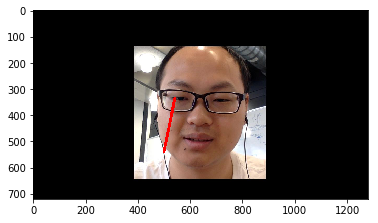

In [168]:
# test
_test_class = Dataset(image_dir_root)
_test_class._contrastdir(person, day)
# _test_class.persondir
# _test_class.daydir
# _test_class.images_dirlist
# _test_class.num_images
# # show_images(_test_class.images_dirlist, cols=10)
# _test_class.annotation_dir
# _test_class._get_camera_address()
# _test_class._read_camara_mx()
# _test_class._annotation_file_reader()
# _test_class._parameter_extracter()
plt.imshow(_test_class.draw_image(9, 8))

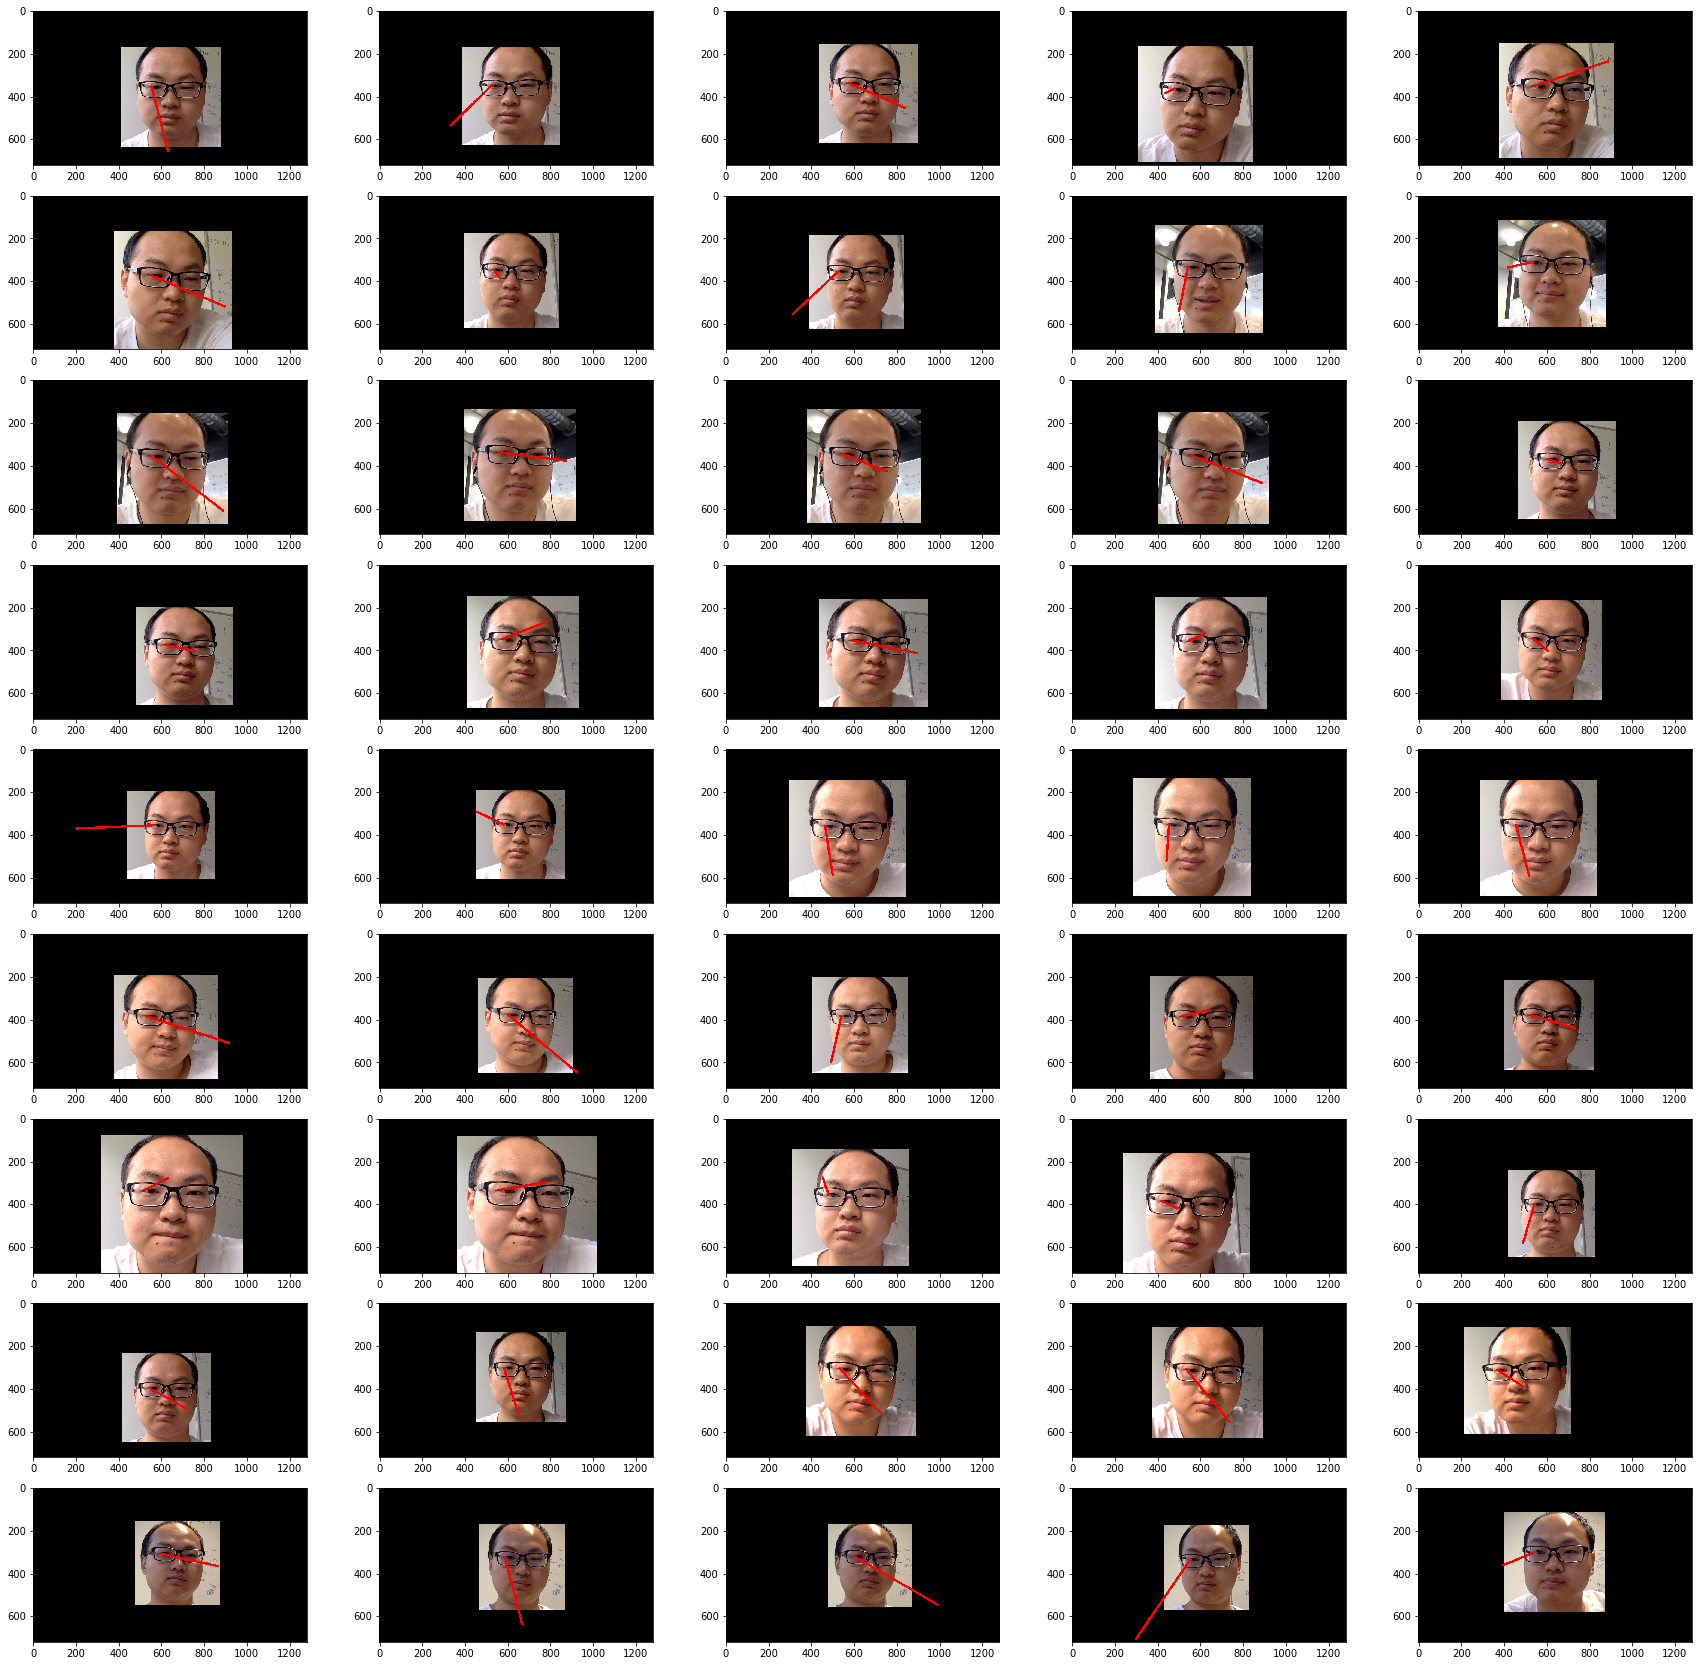

In [170]:
plt.figure(1,(30,30))
for number in range(1, 46):
    plt.subplot(9, 5, number)
    plt.imshow(_test_class.draw_image(number, 8))

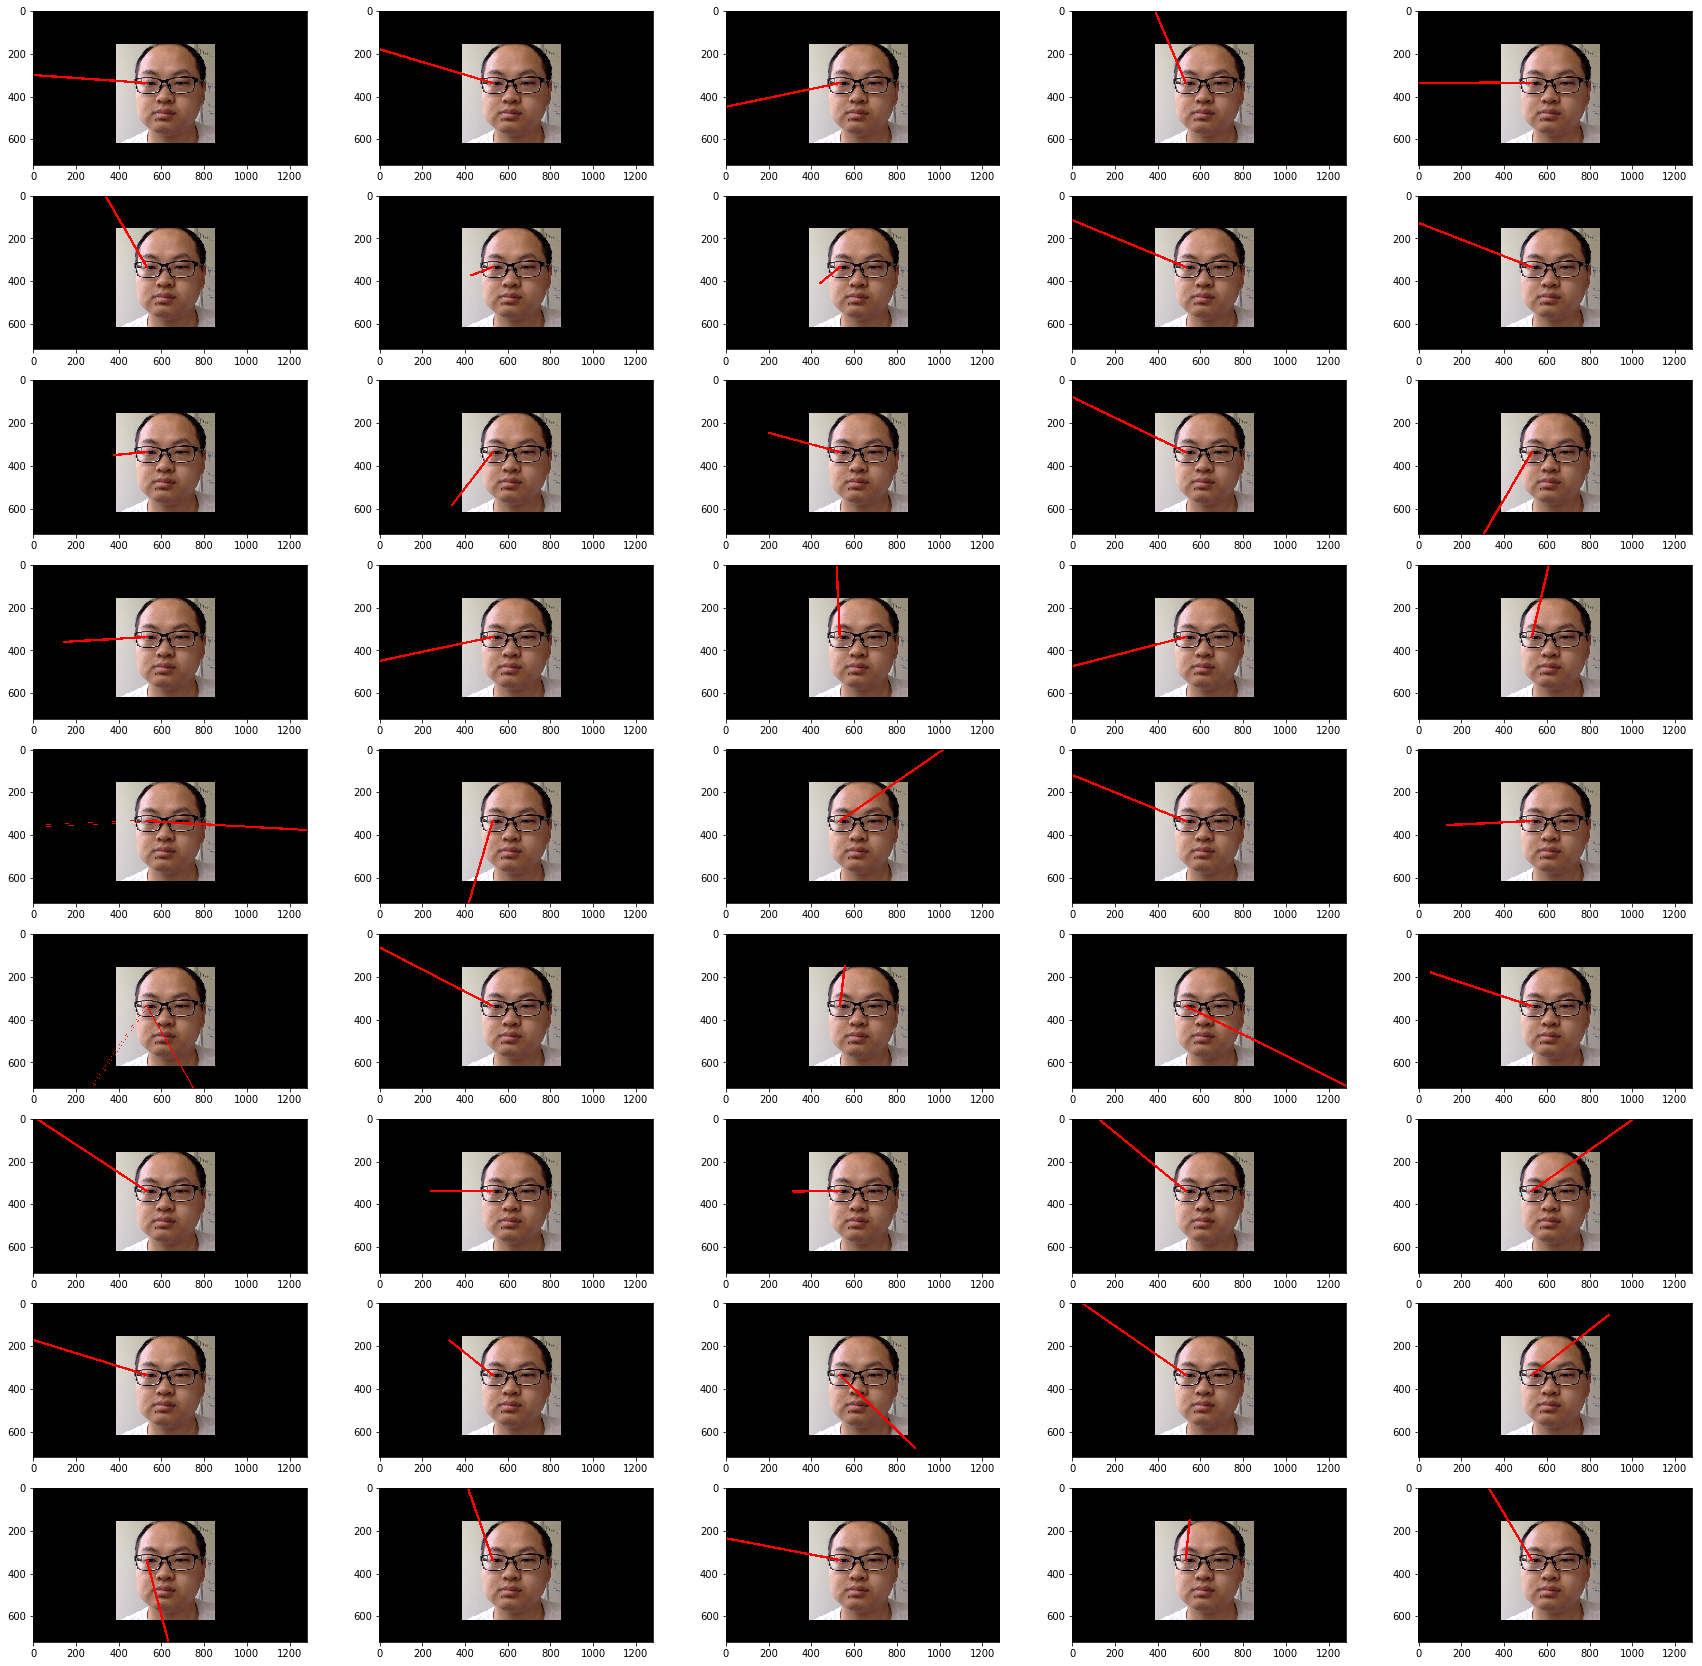

In [172]:
# 同样的照片, 不同的向量组合, 第8组看起来比较对
plt.figure(1,(30,30))
for number in range(1, 46):
    plt.subplot(9, 5, number)
    plt.imshow(_test_class.draw_image(0, number))